### Mixture models / Logistic Regression   

Aims to solve implanaced classification problem

In [4]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import pymc3 as pm
import arviz as az
sns.set()

In [5]:
df = sns.load_dataset('iris').query("species == ('setosa', 'versicolor')")

**Make a difficult iris**

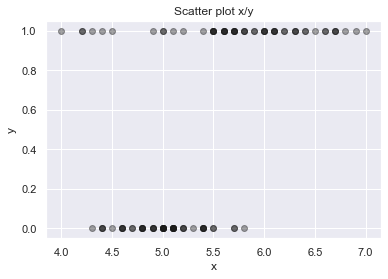

In [43]:
x = df['sepal_length'].values
y = pd.Categorical(df['species']).codes
y = np.concatenate((y, np.ones(6)))
x = np.concatenate((x, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))

plt.scatter(x,y, alpha = 0.4, color = 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot x/y')
plt.show()

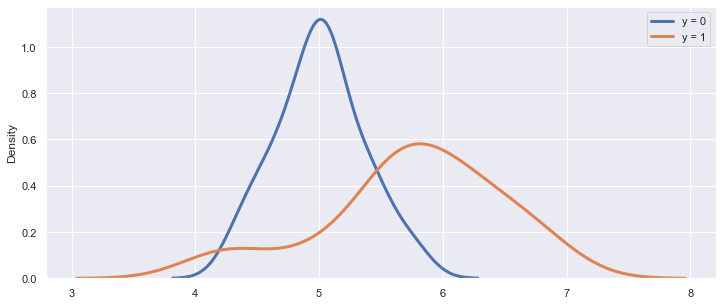

In [161]:
sns.kdeplot(x[np.where(y ==0)], lw =3, label = 'y = 0')
sns.kdeplot(x[np.where(y ==1)], lw =3, label = 'y = 1')
plt.legend(loc = 'upper right')
plt.show()

**Sample ratio**

In [84]:
np.unique(y, return_counts=True)

(array([0., 1.]), array([50, 56], dtype=int64))

**Correlation**

In [132]:
np.corrcoef(x,y)

array([[1.        , 0.55078106],
       [0.55078106, 1.        ]])

**Normalize**

In [7]:
x_norm = x - x.mean()

**Model**

Now that you centrlized x to x_norm, regress a logistic function against y ~ x_norm   
such that $y ~ \frac{1}{1 + e^{-(\alpha + \beta xnorm)}}$                  
then: $y ~ \frac{1}{1 + e^{-(\alpha - \beta x_mean + \beta x)}}$               
True alpha = alpha - beta * x_mean

**Pymc**

In [28]:
with pm.Model() as model:
    alpha_alt = pm.Normal('alpha_alt',mu = 0, sigma = 100)
    beta = pm.Normal('beta', mu = 0, sigma = 10)
    mu = alpha_alt +  beta * x_norm
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    psi = pm.Beta('psi',1,1)
    p = pm.Deterministic('p', psi * 0.5 + (1 - psi) * theta)
    alpha = pm.Deterministic('alpha', alpha_alt - beta * x.mean())
    bd = pm.Deterministic('bd',-alpha / beta)
    y_obs = pm.Bernoulli('y_obs', p, observed = y)
    
    trace = pm.sample(1000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, beta, alpha_alt]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


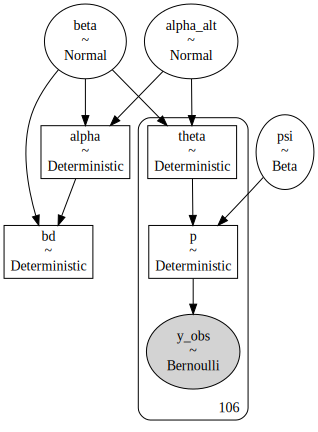

In [29]:
pm.model_graph.model_to_graphviz(model=model )

In [30]:
az.summary(trace,var_names = ['alpha','alpha_alt','beta','psi','bd'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-85.532,32.683,-144.916,-31.064,0.807,0.578,1714.0,1977.0,1.0
alpha_alt,-0.809,0.885,-2.436,0.858,0.021,0.016,1869.0,2080.0,1.0
beta,15.681,5.975,5.640,26.483,0.147,0.105,1732.0,1981.0,1.0
psi,0.303,0.077,0.169,0.453,0.001,0.001,2635.0,2021.0,1.0
bd,5.452,0.055,5.344,5.555,0.001,0.001,2597.0,2160.0,1.0


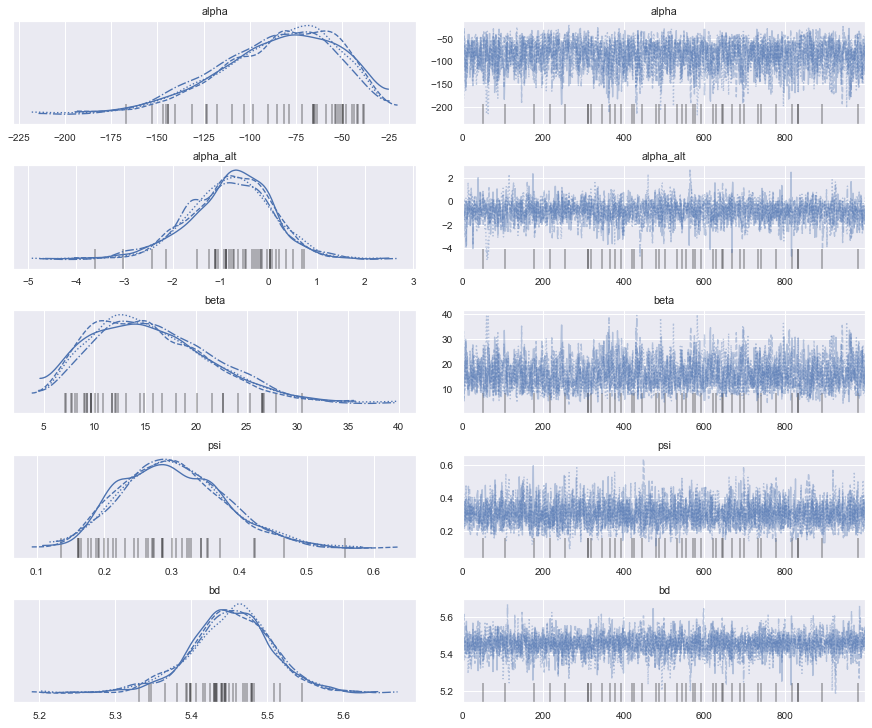

In [31]:
az.plot_trace(trace,var_names = ['alpha','alpha_alt','beta','psi','bd'])
plt.show()

In [61]:
s = az.summary(trace, var_names = ['alpha','beta','bd'])['mean']
alpha = s['alpha']
beta = s['beta']
bd = s['bd']

In [33]:
def logistic(x, alpha, beta):
    z = np.exp(-alpha - beta * x)
    return 1 / (1 + z)

In [63]:
xx = np.linspace(4, 7.2, 1000)
phat = logistic(xx, alpha, beta)

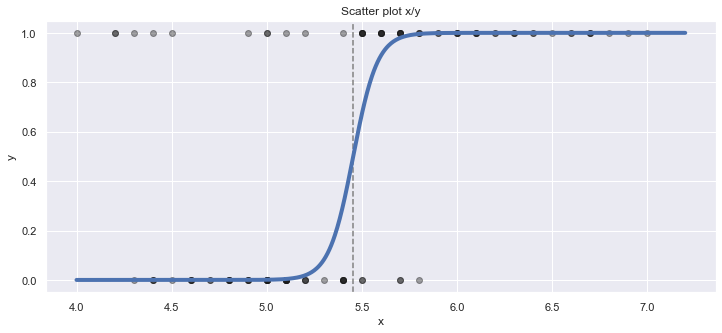

In [64]:
figsize(12,5)
plt.scatter(x,y, alpha = 0.4, color = 'k')
plt.axvline(bd, linestyle = '--', color = 'gray')
plt.plot(xx, phat, lw = 4)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot x/y')
plt.show()

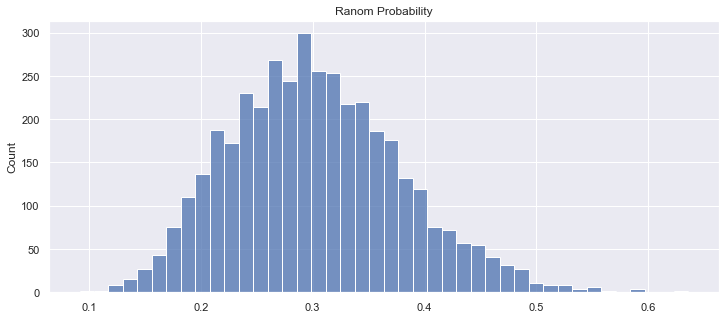

In [70]:
sns.histplot(trace.posterior['psi'].values.reshape(-1))
plt.title('Ranom Probability')
plt.show()

In [75]:
ypred = (logistic(x, alpha, beta) > 0.5).astype(int)

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [79]:
auc = roc_auc_score(y, ypred)
auc

0.8428571428571427

In [80]:
accuracy_score(y, ypred)

0.839622641509434

In [81]:
confusion_matrix(y, ypred)

array([[45,  5],
       [12, 44]], dtype=int64)

**Sklearn Model**

In [131]:
from sklearn.linear_model import LogisticRegression
l = LogisticRegression(C = 2,class_weight = {0:1,1:0.7})
l.fit(x.reshape(-1,1),y)
pred = l.predict(x.reshape(-1,1))
auc = roc_auc_score(y, pred)
print(auc)
confusion_matrix(y, pred)

0.8428571428571427


array([[45,  5],
       [12, 44]], dtype=int64)

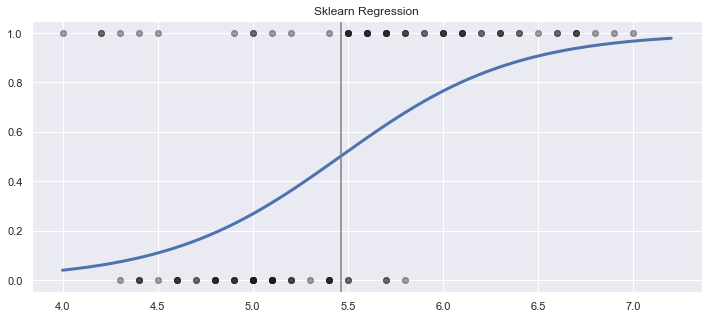

In [130]:
bd1 = xx[np.where(l.predict_proba(xx.reshape(-1,1))[:,1] > 0.5)[0][0]]
plt.plot(xx, l.predict_proba(xx.reshape(-1,1))[:,1], lw = 3)
plt.scatter(x,y, alpha = 0.4, color = 'k')
plt.axvline(bd1, color = 'gray')
plt.title('Sklearn Regression')
plt.show()

#### Correct Data(without noise) Model

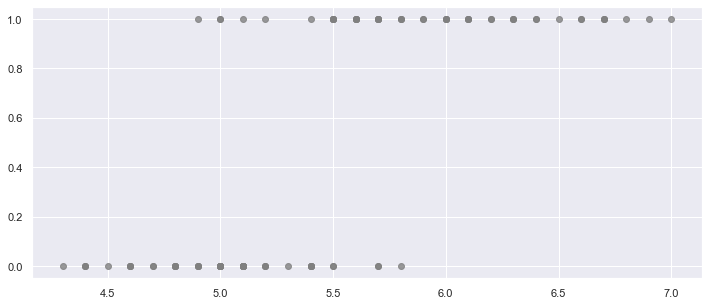

In [137]:
x = df['sepal_length'].values
y = pd.Categorical(df['species']).codes

plt.scatter(x,y, color = 'gray', alpha = .8)
plt.show()

In [138]:
l = LogisticRegression()
l.fit(x.reshape(-1,1),y)
pred = l.predict(x.reshape(-1,1))
auc = roc_auc_score(y, pred)
print(auc)
confusion_matrix(y, pred)

0.89


array([[45,  5],
       [ 6, 44]], dtype=int64)

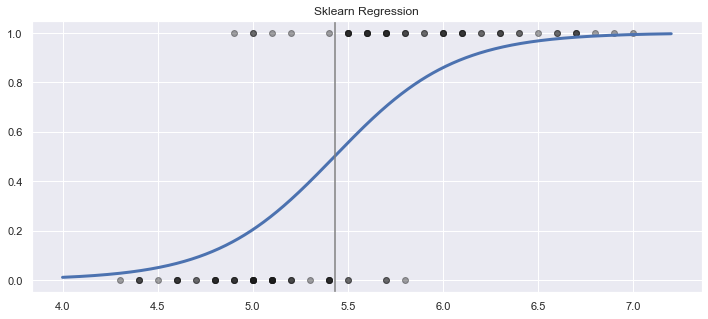

In [139]:
bd1 = xx[np.where(l.predict_proba(xx.reshape(-1,1))[:,1] > 0.5)[0][0]]
plt.plot(xx, l.predict_proba(xx.reshape(-1,1))[:,1], lw = 3)
plt.scatter(x,y, alpha = 0.4, color = 'k')
plt.axvline(bd1, color = 'gray')
plt.title('Sklearn Regression')
plt.show()

In [142]:
print(bd1, bd)

5.431831831831832 5.452


**Decision boundary is pretty close.**